# Random basics - universal approximation theorem

**Objectives**
- implement tool to dynamically choose model weights and activation function fitting a 2d surface with a single neuron
- implement a tool to dynamically choose model widths and depths fitting another 2d surface

**References**

- Michael Nielsen, A visual proof that neural nets can compute any function, [chapter 4](http://neuralnetworksanddeeplearning.com/chap4.html), 2019 

## Fitting a 2d surface with a single neuron

In [1]:
%matplotlib inline

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
import ipywidgets as widgets
from typing import Union, List

Generating a simple plot using one of the standard activation functions

In [123]:
n = int(1e3)
dim = 2
X = torch.zeros((n,dim))
X[:,0].uniform_(-1, 1)
X[:,1].uniform_(-1, 1)
w = torch.ones(2)
y = torch.tanh(X@w)


In [400]:
def plotter_wrapper(X:torch.Tensor, y:torch.Tensor, y_pred:torch.Tensor=None, figsize=(10,10)):

    def dynamic3d_scatter(elev=3, azim=-55):
        fig = plt.figure(figsize=figsize)
        ax = fig.gca(projection="3d")
        ax.scatter(X[:,0], X[:,1], zs=y , c=y, marker="o", alpha=.5)
        if y_pred is not None:
            ax.scatter(X[:,0], X[:,1], zs=y_pred , c="k", marker=".", alpha=.5)
        ax.view_init(elev=elev, azim=azim)  # elev=20., azim=-55
        plt.show()
        
    return dynamic3d_scatter

dynamic3d_scatter = plotter_wrapper(X, y, y_pred=y)
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=3, description='elev', max=180, min=-180), IntSlider(value=-55, descript…

In [329]:
class Model(torch.nn.Module):
    
    def __init__(self, activation_fun:Union[str,callable]="relu", dim_in:int=2, dim_out:int=1):
        super().__init__()
        self.lin = torch.nn.Linear(dim_in, dim_out)
        self.set_activation(activation_fun)
        
    def set_activation(self, fun_name):
        if fun_name is None:
            self.activation = lambda x: x
        else:
            self.activation = getattr(torch.nn.functional, fun_name) if isinstance(fun_name, str) else fun_name
        
    def forward(self, x):
        return self.activation(self.lin(x)).squeeze(1)

device = torch.device("cpu")
m = Model(activation_fun=None, dim_in=dim, dim_out=1)
m.to(device)

Model(
  (lin): Linear(in_features=2, out_features=1, bias=True)
)

In [330]:
loss = torch.nn.functional.mse_loss
opt = torch.optim.Adam(m.parameters(), lr=.01)
print(loss)

<function mse_loss at 0x000001BA2F13DC18>


In [331]:
n_iter = 100

In [332]:
m.train()
for i in range(n_iter):
    y_pred = m(X)
    l = loss(y, y_pred)
    print(l.item())
    l.backward()
    print(m.lin.weight.grad)
    opt.step()
    opt.zero_grad()

0.18910738825798035
tensor([[-0.3377, -0.2560]])
0.17915837466716766
tensor([[-0.3312, -0.2490]])
0.1695488840341568
tensor([[-0.3247, -0.2421]])
0.1602843701839447
tensor([[-0.3183, -0.2351]])
0.15136951208114624
tensor([[-0.3118, -0.2281]])
0.1428082138299942
tensor([[-0.3054, -0.2212]])
0.1346033811569214
tensor([[-0.2990, -0.2143]])
0.12675687670707703
tensor([[-0.2925, -0.2074]])
0.11926958709955215
tensor([[-0.2861, -0.2006]])
0.11214116215705872
tensor([[-0.2798, -0.1937]])
0.10537005215883255
tensor([[-0.2734, -0.1870]])
0.09895338863134384
tensor([[-0.2671, -0.1802]])
0.0928870365023613
tensor([[-0.2608, -0.1735]])
0.08716550469398499
tensor([[-0.2545, -0.1669]])
0.08178185671567917
tensor([[-0.2483, -0.1603]])
0.07672789692878723
tensor([[-0.2421, -0.1538]])
0.07199405133724213
tensor([[-0.2360, -0.1474]])
0.06756947934627533
tensor([[-0.2299, -0.1410]])
0.06344222277402878
tensor([[-0.2238, -0.1347]])
0.05959925428032875
tensor([[-0.2178, -0.1285]])
0.056026604026556015
tens

In [333]:
m.eval()
y_pred = m(X).detach().numpy()
dynamic3d_scatter = plotter_wrapper(X, y, y_pred=y_pred)
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=20, description='elev', max=180, min=-180), IntSlider(value=-55, descrip…

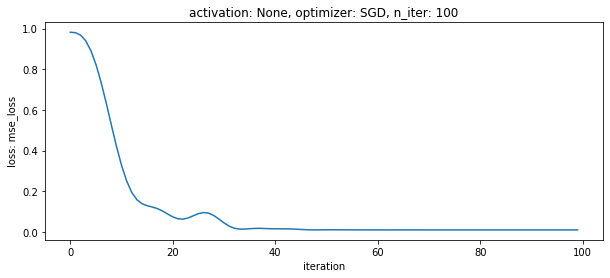

In [335]:
class ModelAndPlot:
    
    def __init__(self, X:torch.Tensor, y:torch.Tensor):
        self.X = X
        self.y = y
        
    def dynamic_fit(self, activation_fun:Union[str,callable]="relu", optimizer:str="Adam", scheduler:str="None",
                    loss:Union[str,callable]="mse_loss", n_iter:int=10, lr:float=.1, max_lr=.1):
        
        self.m = Model(activation_fun=activation_fun, dim_in=self.X.size()[1], dim_out=1)
        self.m.to(device)
        self.opt = getattr(torch.optim, optimizer)(self.m.parameters(), lr=lr)
        self.scheduler = getattr(torch.optim.lr_scheduler, scheduler) if scheduler != "None" else None
        
        if self.scheduler is not None:
            try:
                self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=True)                
            except ValueError:
                self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=False)
        
        self._loss = getattr(torch.nn.functional, loss) if isinstance(loss, str) else loss
        
        self.fit(n_iter)            
        self.plot(n_iter, loss, activation_fun, optimizer)
        
    def fit(self, n_iter):
        
        self.losses = torch.zeros(n_iter, requires_grad=False)    
        
        for i in range(n_iter):
            y_pred = self.m(self.X)
            
            l = self._loss(self.y, y_pred)
            
            self.losses[i] = l.item()
            l.backward()
            
            self.opt.step()
            
            if self.scheduler is not None: 
                self.scheduler.step()
                
            self.opt.zero_grad()
            
        self.m.eval()
        self.y_pred = self.m(X)

        
    def plot(self, n_iter, loss, activation_fun, optimizer):
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(range(n_iter), self.losses.detach().numpy())
        ax.set_xlabel("iteration")
        ax.set_ylabel(f"loss: {loss}")
        ax.set_title(f"activation: {activation_fun}, optimizer: {optimizer}, n_iter: {n_iter}")
        plt.show()
        
MAP = ModelAndPlot(X, y)
MAP.dynamic_fit(activation_fun="relu", optimizer="SGD", scheduler="CyclicLR", loss="mse_loss", 
                n_iter=100, lr=.001, max_lr=.1)

In [337]:
MAP = ModelAndPlot(X, y)
widgets.interact(MAP.dynamic_fit, activation_fun=["relu", "softplus", "sigmoid", "tanh", None], optimizer=["Adam", "RMSprop"],
                 scheduler=["None", "CyclicLR"],
                 loss=["mse_loss", "l1_loss"], n_iter=(1, 100), lr=[1e-3, 1e-2, 1e-1], max_lr=[1,.5, .1]);

interactive(children=(Dropdown(description='activation_fun', options=('relu', 'softplus', 'sigmoid', 'tanh', N…

In [338]:
dynamic3d_scatter = plotter_wrapper(X, y, y_pred=MAP.y_pred.detach().numpy())
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=20, description='elev', max=180, min=-180), IntSlider(value=-55, descrip…

## Fitting a 2d surface with a Dense net

Generating a more complex surface

In [385]:
n = int(5e3)
dim = 2
X = torch.zeros((n,dim))
X[:,0].uniform_(-5, 5)
X[:,1].uniform_(-5, 5)
y = torch.cos(X[:,0])*torch.sin(X[:,1])

In [386]:
dynamic3d_scatter = plotter_wrapper(X, y, y_pred=y)
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=3, description='elev', max=180, min=-180), IntSlider(value=-55, descript…

In [379]:
class HyperModel(torch.nn.Module):
    
    def __init__(self, activation_fun:Union[str,callable]="relu", dim_in:int=2, hidden:List[int]=[5], 
                 dim_out:int=1, output_fun:Union[str,callable]="linear"):
        super().__init__()
        self.dense = [torch.nn.Linear(dim_in, hidden[0])]
        if len(hidden) > 1:
            self.dense += [torch.nn.Linear(hidden[i], hidden[i+1]) for i in range(len(hidden)-1)]
        self.dense += [torch.nn.Linear(hidden[-1], dim_out)]
        self.dense = torch.nn.ModuleList(self.dense)
        self.set_activation(activation_fun)
        self.set_output_fun(output_fun)
        
    def set_activation(self, fun_name):
        self.activation = getattr(torch.nn.functional, fun_name) if isinstance(fun_name, str) else fun_name
        
    def set_output_fun(self, fun_name):
        if fun_name == "linear":
            self.output_fun = lambda x: x
        else:
            self.output_fun = getattr(torch.nn.functional, fun_name) if isinstance(fun_name, str) else fun_name
        
        
    def forward(self, x):
        o = x.clone()
        for i,l in enumerate(self.dense):
            if i<len(self.dense):
                o = self.activation(l(o))
            else:
                o = self.output_fun(l(o))
        return o.squeeze(1)

device = torch.device("cpu")
m = HyperModel(activation_fun="relu", dim_in=dim, hidden=[3,2], dim_out=1, output_fun="linear")
m.to(device)
print(m.dense)
m(X).size()

ModuleList(
  (0): Linear(in_features=2, out_features=3, bias=True)
  (1): Linear(in_features=3, out_features=2, bias=True)
  (2): Linear(in_features=2, out_features=1, bias=True)
)


torch.Size([1000])

output_fun linear
HyperModel(
  (dense): ModuleList(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=2, bias=True)
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
)
number of parameters 30 => [torch.Size([5, 2]), torch.Size([5]), torch.Size([2, 5]), torch.Size([2]), torch.Size([1, 2]), torch.Size([1])]


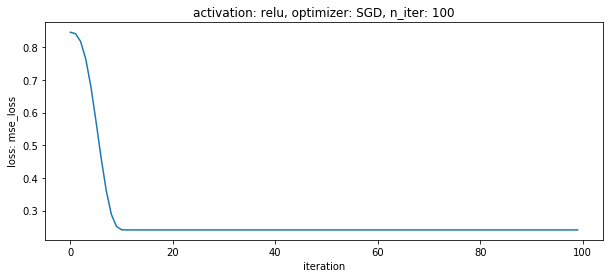

In [387]:
class HyperModelAndPlot(ModelAndPlot):
    
    def __init__(self, X:torch.Tensor, y:torch.Tensor):
        super().__init__(X, y)
        
    def dynamic_fit(self, activation_fun:Union[str,callable]="relu", optimizer:str="Adam", scheduler:str="None",
                    loss:Union[str,callable]="mse_loss", n_iter:int=10, lr:float=.1, max_lr=.1, 
                    hidden:str="5,2", output_fun:Union[str,callable]="linear"):
        
        _hidden = [int(v) for v in hidden.split(",")]
        print("output_fun", output_fun)
        self.m = HyperModel(activation_fun=activation_fun, dim_in=self.X.size()[1], hidden=_hidden, dim_out=1,
                            output_fun=output_fun)
        print(self.m)
        print(f"number of parameters {sum([np.prod(v.size()) for v in self.m.parameters()])} => {[v.size() for v in self.m.parameters()]}")
        self.m.to(device)
        self.opt = getattr(torch.optim, optimizer)(self.m.parameters(), lr=lr)
        self.scheduler = getattr(torch.optim.lr_scheduler, scheduler) if scheduler != "None" else None
        
        if self.scheduler is not None:
            try:
                self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=True)                
            except ValueError:
                self.scheduler = self.scheduler(self.opt, base_lr=lr, max_lr=max_lr, step_size_up=n_iter//2, cycle_momentum=False)
        
        self._loss = getattr(torch.nn.functional, loss) if isinstance(loss, str) else loss
        
        self.fit(n_iter)            
        self.plot(n_iter, loss, activation_fun, optimizer)
        
        
MAP = HyperModelAndPlot(X, y)
MAP.dynamic_fit(activation_fun="relu", optimizer="SGD", scheduler="CyclicLR", loss="mse_loss", 
                n_iter=100, lr=.001, max_lr=.1, hidden="5,2", output_fun="linear")

In [405]:
y_s = (y-y.min())/y.std() # standardizing

MAP = HyperModelAndPlot(X, y_s)
widgets.interact(MAP.dynamic_fit, 
                 activation_fun=["relu", "softplus", "sigmoid", "tanh"], 
                 output_fun=["relu", "softplus", "sigmoid", "tanh", "linear"],
                 optimizer=["Adam", "RMSprop"],
                 scheduler=["None", "CyclicLR"], hidden=widgets.Combobox(value="5,2"),
                 loss=["mse_loss", "l1_loss"], n_iter=widgets.IntText(value=50), 
                 lr=widgets.FloatText(value=.1), max_lr=widgets.FloatText(value=.1));

interactive(children=(Dropdown(description='activation_fun', options=('relu', 'softplus', 'sigmoid', 'tanh'), …

In [407]:
dynamic3d_scatter = plotter_wrapper(X, y_s, y_pred=MAP.y_pred.detach().numpy())
widgets.interact(dynamic3d_scatter, elev=(-180,180), azim=(-180,180));

interactive(children=(IntSlider(value=3, description='elev', max=180, min=-180), IntSlider(value=-55, descript…